In [ ]:
pip install pyvi

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU,Input, GlobalMaxPooling1D, LayerNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils

In [ ]:
# Load data
def get_data(path):
    return pd.read_csv(path)
data_train = get_data('/content/drive/MyDrive/data/train.csv')
data_test = get_data('/content/drive/MyDrive/data/test.csv')

In [ ]:
data = pd.concat([data_train, data_test], ignore_index=True)

In [ ]:
data.to_csv("data-processing.csv", index=False)

In [ ]:
sentiment_data = get_data('/content/data-processing.csv')

In [ ]:
# Preprocessing data & Prepare Data for Training
input_data = sentiment_data['comment'].values
input_label = sentiment_data['label'].values

label_dict = {'POS': 2, 'NEU': 1, 'NEG': 0}
input_pre = []
label_with_accent = []
for idx, dt in enumerate(input_data):
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
  input_text_pre= " ".join(input_text_pre)
  input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode('utf-8'))
  input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
  input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)
  input_pre.append(input_text_pre_accent)
  input_pre.append(input_text_pre_no_accent)
  label_with_accent.append(input_label[idx])
  label_with_accent.append(input_label[idx])

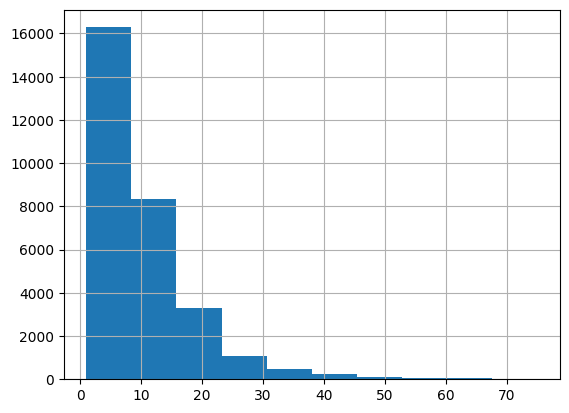

In [ ]:
seq_len = [len(i.split()) for i in input_pre[0:30000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()



In [ ]:
label_idx = [label_dict[i] for i in label_with_accent]
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=3, dtype='float32')
tokenizer_data = Tokenizer(oov_token='<OOV>', filters = '', split = ' ')
tokenizer_data.fit_on_texts(input_pre)

tokenized_data_text = tokenizer_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenized_data_text, padding = 'post', maxlen = 32)

pickle.dump(tokenizer_data, open('tokenizer_data.pkl', 'wb'))

print('input data.shape ', vec_data.shape)
data_vocab_size = len(tokenizer_data.word_index)+1
print('data_vocab_size: ', data_vocab_size)

X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size = 0.2, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train , y_train, test_size = 0.1, random_state = 42)
print('training sample: ', len(X_train))
print('validation sample: ', len(X_val))
print('test sample: ', len(X_test))

input data.shape  (51198, 32)
data_vocab_size:  9399
training sample:  36862
validation sample:  10240
test sample:  4096


In [ ]:
def generate_model():
    dropout_threshold = 0.5
    input_dim = data_vocab_size
    output_dim = 32
    input_length = 32
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(input_layer)

    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, kernel_initializer=initializer, return_sequences=True), merge_mode='concat')(feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

    bi_lstm_feature = Bidirectional(GRU(units=32, dropout=dropout_threshold, kernel_initializer=initializer, return_sequences=True), merge_mode='concat')(bi_lstm_feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)


    combined_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature])
    combined_feature = GlobalMaxPooling1D()(combined_feature)
    combined_feature = LayerNormalization()(combined_feature)

    classifier = Dense(40, activation='relu')(combined_feature)
    classifier = Dropout(0.5)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)  # Changed combine_feature to classifier
    model = tf.keras.Model(inputs=input_layer, outputs=classifier)
    return model

model = generate_model()
optimizer = Adam(0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


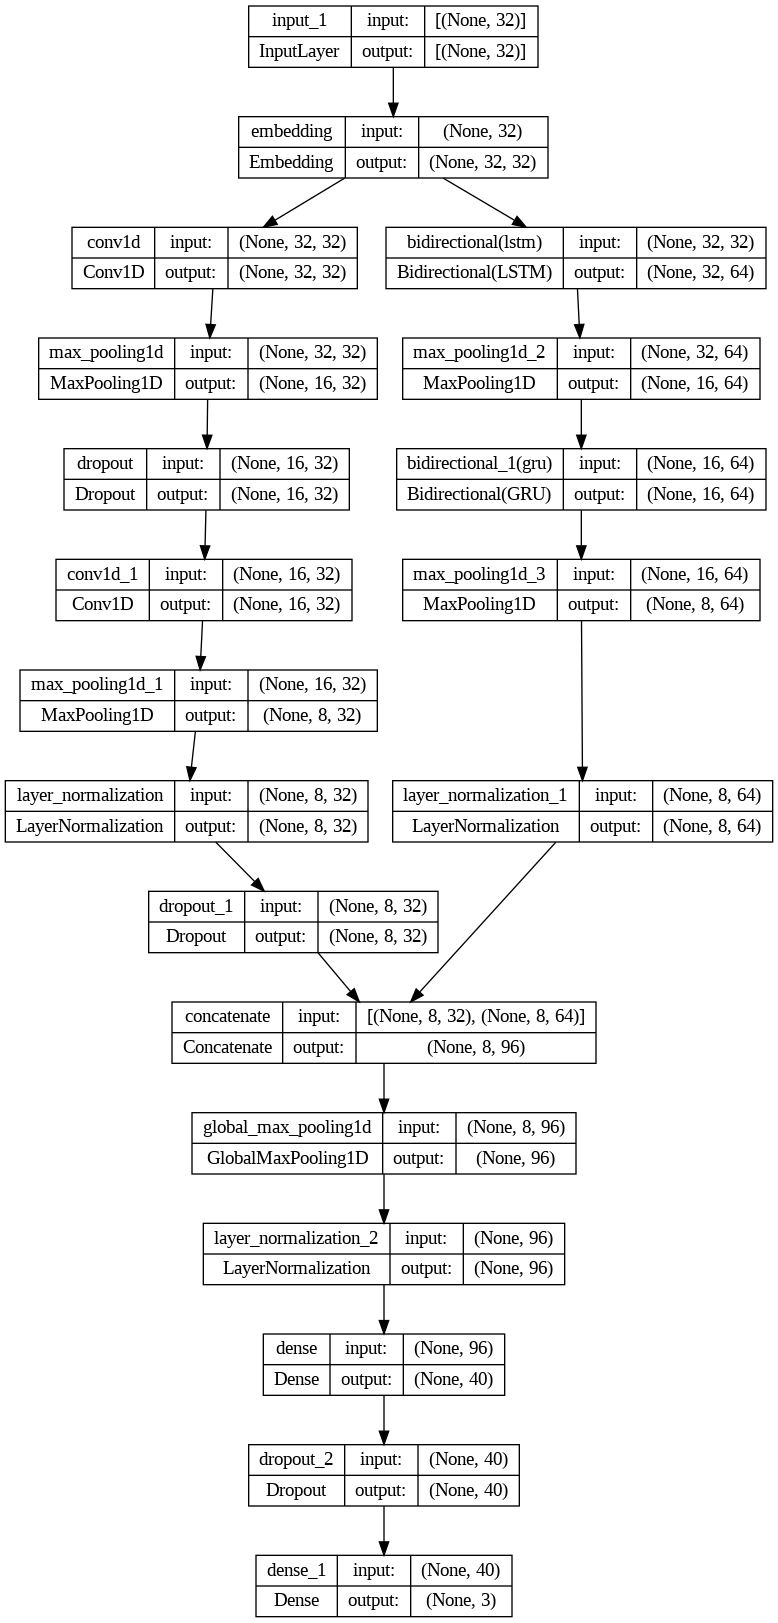

In [ ]:
dot_img_file = 'model_visualize.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping, checkpoint])


Epoch 1/100
1152/1152 [==============================] - 90s 68ms/step - loss: 0.7596 - accuracy: 0.6787 - val_loss: 0.6351 - val_accuracy: 0.7473
Epoch 2/100
   2/1152 [..............................] - ETA: 1:03 - loss: 0.5495 - accuracy: 0.7656

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1152/1152 [==============================] - 76s 66ms/step - loss: 0.6091 - accuracy: 0.7562 - val_loss: 0.6073 - val_accuracy: 0.7528
Epoch 3/100
1152/1152 [==============================] - 71s 62ms/step - loss: 0.5582 - accuracy: 0.7732 - val_loss: 0.6004 - val_accuracy: 0.7603
Epoch 4/100
1152/1152 [==============================] - 73s 63ms/step - loss: 0.5300 - accuracy: 0.7845 - val_loss: 0.6077 - val_accuracy: 0.7633
Epoch 5/100
1152/1152 [==============================] - 77s 67ms/step - loss: 0.5019 - accuracy: 0.7959 - val_loss: 0.6025 - val_accuracy: 0.7682
Epoch 6/100
1152/1152 [==============================] - 83s 72ms/step - loss: 0.4815 - accuracy: 0.8045 - val_loss: 0.6119 - val_accuracy: 0.7645
Epoch 7/100
1152/1152 [==============================] - 70s 61ms/step - loss: 0.4625 - accuracy: 0.8139 - val_loss: 0.6178 - val_accuracy: 0.7664
Epoch 8/100
1152/1152 [==============================] - 73s 63ms/step - loss: 0.4491 - accuracy: 0.8225 - val_loss: 0.6348 - val_

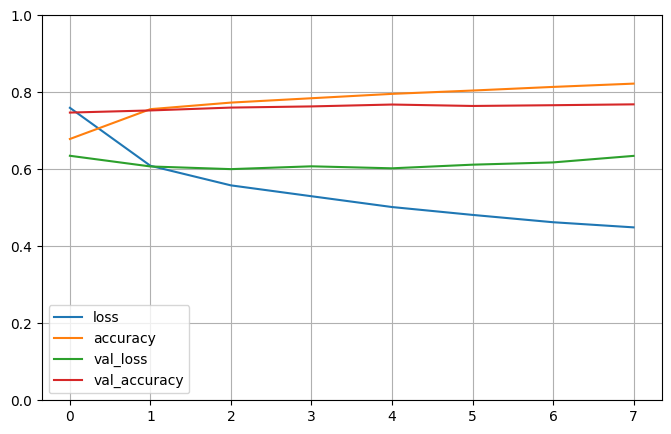

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig('keras_learning_curve_plot')
plt.show()

In [ ]:
model.load_weights('/content/best_model.h5')
model.evaluate(X_test, y_test)

128/128 [==============================] - 5s 13ms/step - loss: 0.5522 - accuracy: 0.7739


[0.5522057414054871, 0.77392578125]

In [ ]:
# inference Model with Input Test
def preprocessing_raw_input(raw_input, tokenizer):
   input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
   input_text_pre = ' '.join(input_text_pre)
   input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
   print('text preprocessed: ', input_text_pre_accent)
   tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
   vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=32)
   return vec_data
def inference_model(input_feature, model):
  output = model(input_feature).numpy()[0]
  result = output.argmax()
  conf = float(output.max())
  label_dict = {2: 'POS', 1: 'NEU', 0: 'NEG'}
  label = list(label_dict.keys())
  return label[int(result)], conf

def prediction(raw_input, tokenizer, model):
  input_model = preprocessing_raw_input(raw_input, tokenizer)
  result, conf = inference_model(input_model, model)
  kq = ''
  if result == 0:
      kq = 'tích cực'
  elif result == 1:
      kq = 'trung tính'
  else:
      kq = 'tiêu cực'
  return kq, conf

my_model = generate_model()
my_model = load_model('/content/best_model.h5')

with open(r'tokenizer_data.pkl', 'rb') as input_file:
  my_tokenizer = pickle.load(input_file)

print(prediction('áo bao đẹp', my_tokenizer, my_model))

text preprocessed:  áo bao đẹp
('tích cực', 0.9808942675590515)


In [ ]:
while True:
    text = input()
    if text == 'end':
        break
    else:
        prediction_result = prediction(text, my_tokenizer, my_model)[0]
        print(str(prediction_result) + "\n")


KeyboardInterrupt: Interrupted by user